In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from io import StringIO

## Part 1. Treasury Yield

### Fetching Data and Global Styling

In [2]:
# Treasury yield curve data URL
URL = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025"

# Function to fetch yield data
def fetch_yield_data():
    response = requests.get(URL)
    if response.status_code != 200:
        print("Failed to retrieve data")
        return None

    soup = BeautifulSoup(response.text, "html.parser")

    # Extract table data
    table = soup.find("table")
    if not table:
        print("No table found on the page")
        return None

    # Convert table HTML to DataFrame (Fixing FutureWarning)
    table_html = str(table)
    df = pd.read_html(StringIO(table_html))[0]  # Using StringIO to avoid FutureWarning
    return df

def preprocess_yield_data(df, start_date=None):
    if df is None or df.empty:
        print("No data available.")
        return None

    df['Date'] = pd.to_datetime(df['Date'])
    if start_date is None:
        start_date = datetime.today() - pd.Timedelta(days=7)  # Default to last 7 days
    else:
        start_date = pd.to_datetime(start_date)

    df_recent = df[df['Date'] >= start_date.strftime('%Y-%m-%d')]
    df_recent = df_recent.iloc[[0, -1]]  # Select first and last row within range
    df_recent = df_recent.dropna(axis=1).set_index('Date').T
    return df_recent

def add_texts(ax, fig, title, subtitle, source):
    ax.plot([0.05, .9], [.95, .95], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
    ax.add_patch(plt.Rectangle((0.05, .95), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth=0))
    ax.text(x=0.05, y=.9, s=title, transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=1)
    ax.text(x=0.05, y=.87, s=subtitle, transform=fig.transFigure, ha='left', fontsize=12, alpha=1)
    ax.text(x=0.05, y=0.12, s=source, transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)


def style_yield_curve(ax, fig):
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12)
    ax.yaxis.set_tick_params(pad=2, labelsize=12)
    ax.spines[['top', 'right', 'bottom']].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1.1)
    plt.subplots_adjust(bottom=0.2, top=0.85)
    fig.patch.set_facecolor('white')

df = fetch_yield_data()

### Code: Plotting Yield Curve and Style

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_yield_curve(df, title, subtitle, source, start_date=None):
    df_recent = preprocess_yield_data(df, start_date)
    if df_recent is None:
        return

    fig, ax = plt.subplots(figsize=(12, 7.5), dpi=96)
    colors = ['#006BA2', '#3EBCD2']
    for i, date in enumerate(df_recent.columns):
        ax.plot(df_recent.index, df_recent[date], linestyle='-', linewidth=1.2, color=colors[i % len(colors)], label=date.strftime('%Y-%m-%d'))

    style_yield_curve(ax, fig)
    add_texts(ax, fig, title, subtitle, source)
    ax.legend(loc="best", fontsize=8)
    plt.show()


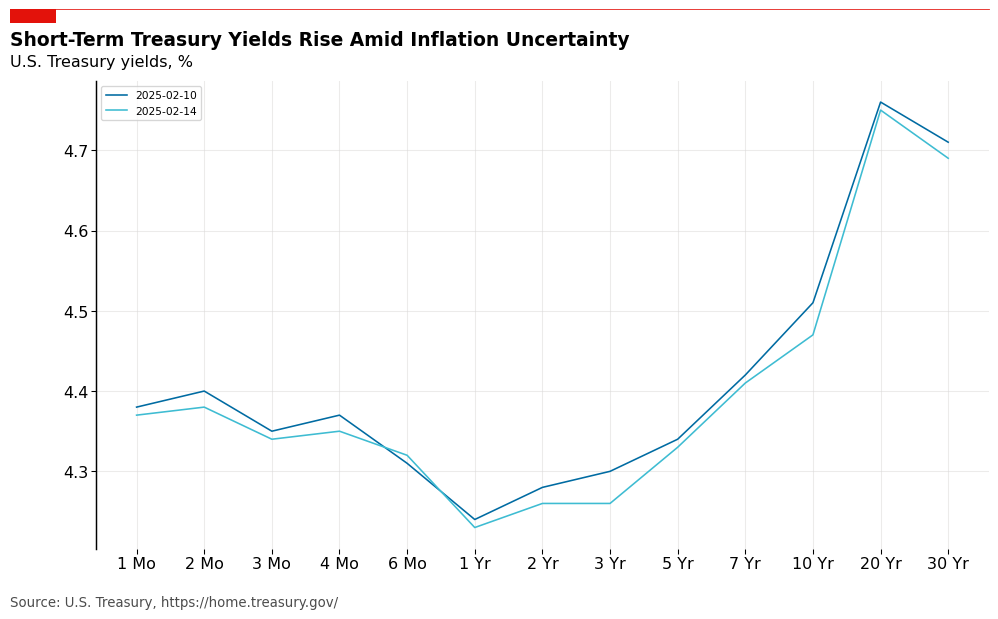

In [5]:
# Example Usage
title = "Short-Term Treasury Yields Rise Amid Inflation Uncertainty"
subtitle = "U.S. Treasury yields, %"
source = "Source: U.S. Treasury, https://home.treasury.gov/"
start_date = "2025-02-10"  # Example start date
plot_yield_curve(df, title, subtitle, source, start_date)

---
### Column Data: Changes in different Maturity Over a Period

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date

def preprocess_column_data(df, start_date, column_name):
    if df is None or df.empty or column_name not in df.columns:
        print("No data available or column not found.")
        return None

    df['Date'] = pd.to_datetime(df['Date']).dt.date
    start_date = pd.to_datetime(start_date).date()
    df_filtered = df[df['Date'] >= start_date]
    return df_filtered[['Date', column_name]]

def plot_column_trend(df, start_date, column_name, title, subtitle, source):
    df_column = preprocess_column_data(df, start_date, column_name)
    if df_column is None:
        return

    fig, ax = plt.subplots(figsize=(12, 7.5), dpi=96)
    ax.plot(df_column['Date'], df_column[column_name], linestyle='-', color='#006BA2', linewidth=1.2)

    # ax.set_xlabel("Date", fontsize=12)
    # ax.set_ylabel(f"{column_name} Yield (%)", fontsize=12)
    # ax.set_title(title, fontsize=14, weight='bold')
    # ax.grid(True, linestyle='--', alpha=0.6)
    style_yield_curve(ax, fig)
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))  # Show only date
    add_texts(ax, fig, title, subtitle, source)
    plt.show()

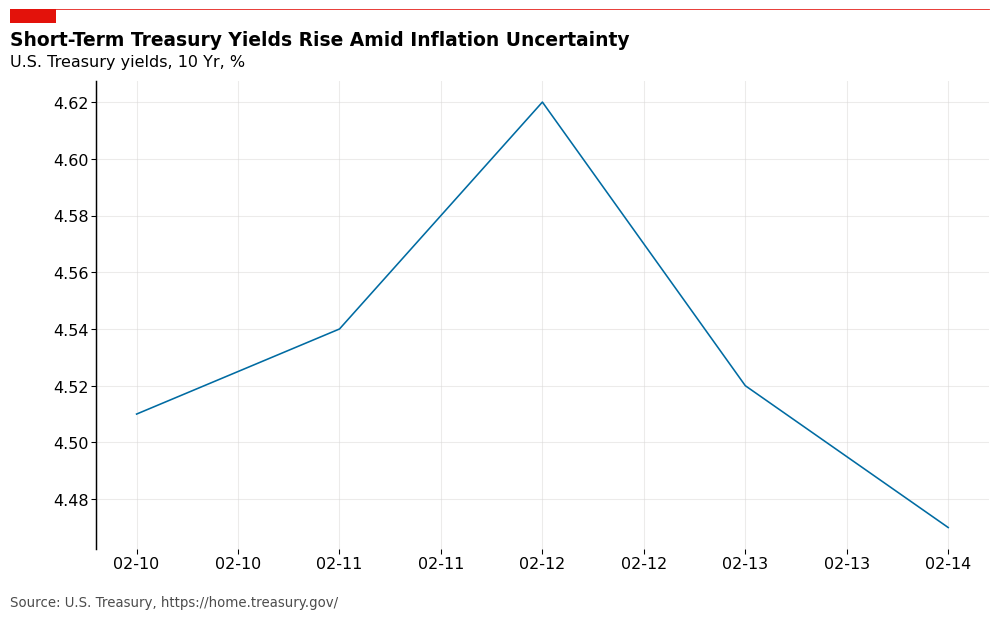

In [13]:
# Example Usage
start_date = "2025-02-10"  # Example start date
target_column = "10 Yr"
title = "Short-Term Treasury Yields Rise Amid Inflation Uncertainty"
subtitle = f"U.S. Treasury yields, {target_column}, %"
source = "Source: U.S. Treasury, https://home.treasury.gov/"

plot_column_trend(df, start_date, target_column, title, subtitle, source)

---
## Part 2. Stock Market
### Presets

In [6]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the date range
today = datetime.now().date()
start_date = today - timedelta(days=6)

# Fetch TSLA data
ticker = 'TSLA'
data = yf.download(ticker, start=start_date, end=today, progress=False)

# Ensure data is not empty
if not data.empty:
    # Find the first and last available trading day
    start_price = data['Close'].dropna().iloc[0].item()  # First valid price
    end_price = data['Close'].dropna().iloc[-1].item()  # Last valid price
    first_trading_day = data.index[0].date()
    last_trading_day = data.index[-1].date()  # Last available trading day

    # Calculate return
    weekly_return = (end_price - start_price) / start_price * 100
    print(f"The return for {ticker} from {first_trading_day} to {last_trading_day} is {weekly_return:.2f}%")
else:
    print("No data available for the specified date range.")


The return for TSLA from 2025-02-11 to 2025-02-14 is 8.32%


In [7]:
data

Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2025-02-11  328.500000  349.369995  325.100006  345.799988  118543400
2025-02-12  336.510010  346.399994  329.119995  329.940002  105382700
2025-02-13  355.940002  358.690002  342.850006  345.000000   89441500
2025-02-14  355.839996  362.000000  347.500000  360.619995   68054700

In [8]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# 维基百科恒生指数页面 URL
url = "https://zh.wikipedia.org/wiki/%E6%81%92%E7%94%9F%E6%8C%87%E6%95%B8"

# 发送请求并获取页面内容
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# 查找所有表格
tables = soup.find_all("table", {"class": "wikitable"})

# 解析目标表格（一般为页面中的第一个或第二个表格）
df_list = pd.read_html(str(tables))

# 选择包含成份股的表格（通常是第一个）
hs_index_df = df_list[8]

# 如果列是 MultiIndex，將其轉換為單層次列
hs_index_df.columns = ['_'.join(col) for col in hs_index_df.columns]

# 保存為 Excel 文件
hs_index_df.to_excel("恒生指数成份股.xlsx", index=False)

print("Excel 文件已保存：恒生指数成份股.xlsx")


C:\Users\ROG\AppData\Local\Temp\ipykernel_12772\3840266527.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(str(tables))


Excel 文件已保存：恒生指数成份股.xlsx
